In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Load dataset
df = pd.read_csv("lstm_ready_traffic_data.csv")
scaler = MinMaxScaler()
df['scaled_traffic_volume'] = scaler.fit_transform(df[['Total_Traffic_Volume']])
# If 'day_of_week' is text, convert to numeric
if df['day_of_week'].dtype == 'object':
    df['day_of_week'] = df['day_of_week'].astype('category').cat.codes

# Select features and target
features = ['hour', 'day_of_week', 'month', 'year', 'road_name_encoded',
            'location_encoded', 'suburb_encoded', 'average_speed',
            'maximum_speed', 'Speeding_Incident', 'Speeding_Incident_Avg_Speed']
target = 'scaled_traffic_volume'

# Convert features and target to float32 (required by LSTM)
X = df[features].values.astype('float32')
y = df[target].values.astype('float32')

# Create sequences
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)


In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
def build_trimodel(hp):
    model = Sequential()

    # Layer 1
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=16),
        activation='tanh',
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Layer 2
    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16),
        activation='tanh',
        return_sequences=True
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Layer 3
    model.add(LSTM(
        units=hp.Int('lstm_units_3', min_value=8, max_value=32, step=8),
        activation='tanh'
    ))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Output
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='mse'
    )

    return model

In [ ]:
from keras_tuner.tuners import Hyperband

tuner = Hyperband(
    build_trimodel,
    objective='val_loss',     # We want to minimize validation loss
    max_epochs=30,            # Max training epochs (used in early-stopping-like pruning)
    factor=3,                 # How much fewer resources to allocate to each bracket
    directory='traffic_tuner',
    project_name='hyperband_trimodel'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,               # Matches max_epochs above
    batch_size=64,
    verbose=1
)

Trial 90 Complete [00h 26m 53s]
val_loss: 0.0074034095741808414

Best val_loss So Far: 0.006473612505942583
Total elapsed time: 11h 39m 25s


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the best model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,               # You can safely go higher with early stopping
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 88s 93ms/step - loss: 0.0103 - val_loss: 0.0077
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 79s 90ms/step - loss: 0.0070 - val_loss: 0.0078
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 79s 86ms/step - loss: 0.0069 - val_loss: 0.0077
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - loss: 0.0069 - val_loss: 0.0078
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 6/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 87ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 7/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 88s 95ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 8/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 9/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 78s 86ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 10/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 69s 87ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 11/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - loss: 0.0061 - val_loss: 0.0079
Epoch 12/50
789/789 ━━━━━━━━━━

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load predictions and actual values
y_pred = np.load("y_hyperband.npy")

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Print results
print("\n✅ Hyperband-Optimized Trimodel Results:")
print(f"🔹 RMSE: {rmse:.4f}")
print(f"🔹 MAE : {mae:.4f}")
print(f"🔹 R²  : {r2:.4f}")
print(f"🔹 MSE : {mse:.4f}")



✅ Hyperband-Optimized Trimodel Results:
🔹 RMSE: 0.0865
🔹 MAE : 0.0524
🔹 R²  : 0.0369
🔹 MSE : 0.0075


<ipython-input-16-0edfd299858b>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


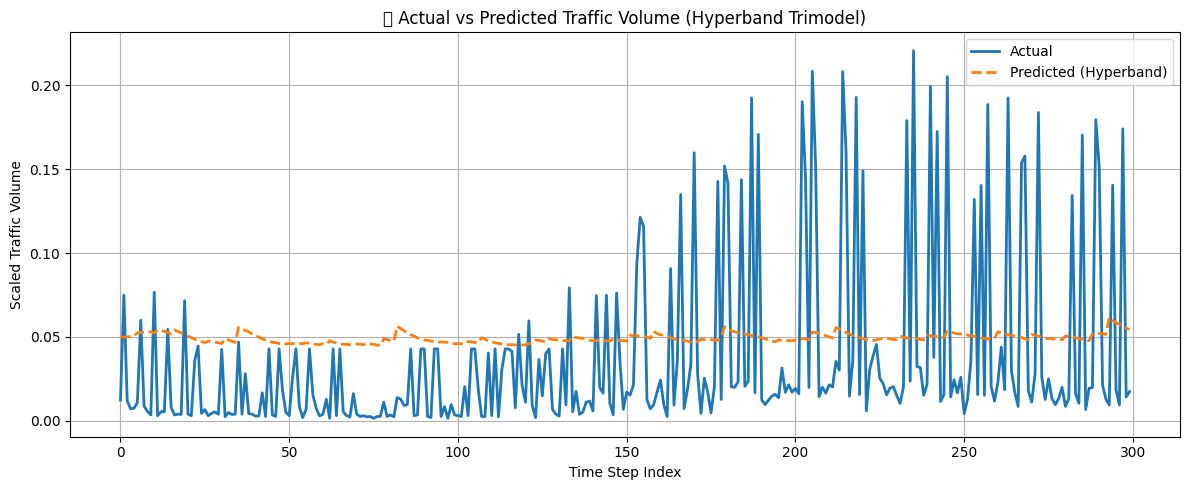

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test[:300], label='Actual', linewidth=2)
plt.plot(y_pred_hyperband[:300], label='Predicted (Hyperband)', linestyle='--', linewidth=2)
plt.title("📊 Actual vs Predicted Traffic Volume (Hyperband Trimodel)")
plt.xlabel("Time Step Index")
plt.ylabel("Scaled Traffic Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


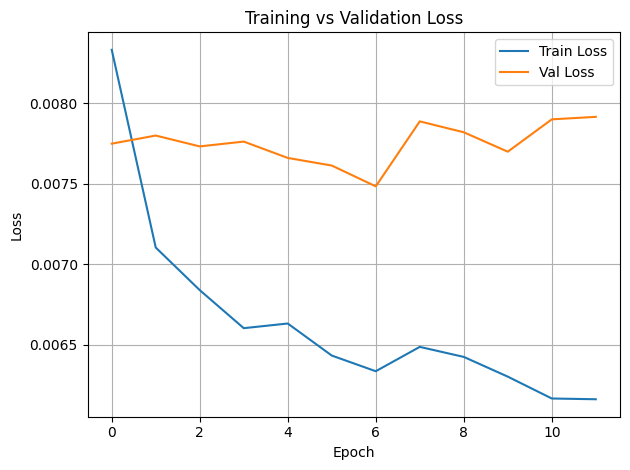

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

np.save("y_hyperband.npy", y_pred_hyperband)

In [ ]:
from google.colab import files

files.download("y_hyperband.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>